### Application of classic linear regression to the Ames dataset

**Introduction**

This is a beginner-level attempt to apply the main Regularisation algorithms to the Ames dataset. To minimise complexity, I have avoided extensive feature engineering (e.g. polynomial regression, feature combination etc). 

However I do recommend the following notebooks on Kaggle for a more in-depth treatment of Exploration and Feature Engineering methods

- *Comprehensive Data Exploration with Python* (**Pedro Marcelino**, 2017, url: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)

- *A study on Regression applied to the Ames dataset* (**Julien Cohen-Solal**, url: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)

It demonstrates the superiority of ridge regression techniques over simple linear regression, with the former able to achieve R-quared scores of up to 0.91, vs 0.83 for the latter) 

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x) #avoid scientific notation for big numbers
%matplotlib inline

In [2]:
# Get data
train = pd.read_csv("train.csv")
print("train : " + str(train.shape))

train : (1460, 81)


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Check for duplicate entries
idsUnique = len(set(train.Id))
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

# Drop Id column
train.drop("Id", axis = 1, inplace = True)

There are 0 duplicate IDs for 1460 total entries


**Preprocessing**

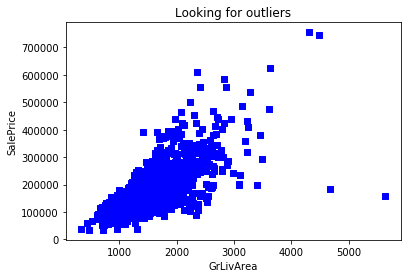

In [5]:
# Looking for outliers
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

There are 2 extreme outliers on the bottom right, really large houses that sold for really cheap. More generally, the author of the dataset recommends removing 'any houses with more than 4000 square feet' from the dataset.  
Reference : https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

In [6]:
#exclude houses larger than 4000 sq ft from training set
train = train[train.GrLivArea < 4000]

Log transform the sale price. This means errors in predicting expensive houses will not have undue effect vs errors in cheap houses. (For instance, a 10% error in a 10 mln value house should not weigh more than a 10% error in a 100k value house)

In [7]:
# Log transform t
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

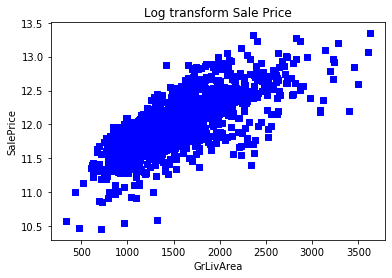

In [8]:
#Plot result
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Log transform Sale Price")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()


In [9]:
#Inspect dataframe for all features containing at least one null value. Check data type
for i in range(len(train.columns)):
    if sum(pd.isnull(train[train.columns[i]]))>0:
        print([train.columns[i], train[train.columns[i]].dtypes, sum(pd.isnull(train[train.columns[i]]))])

['LotFrontage', dtype('float64'), 259]
['Alley', dtype('O'), 1365]
['MasVnrType', dtype('O'), 8]
['MasVnrArea', dtype('float64'), 8]
['BsmtQual', dtype('O'), 37]
['BsmtCond', dtype('O'), 37]
['BsmtExposure', dtype('O'), 38]
['BsmtFinType1', dtype('O'), 37]
['BsmtFinType2', dtype('O'), 38]
['Electrical', dtype('O'), 1]
['FireplaceQu', dtype('O'), 690]
['GarageType', dtype('O'), 81]
['GarageYrBlt', dtype('float64'), 81]
['GarageFinish', dtype('O'), 81]
['GarageQual', dtype('O'), 81]
['GarageCond', dtype('O'), 81]
['PoolQC', dtype('O'), 1451]
['Fence', dtype('O'), 1176]
['MiscFeature', dtype('O'), 1402]


In [10]:
#For null values, compute average if they are numerical, or show set of values if categorical
for i in range(len(train.columns)):
    if sum(pd.isnull(train[train.columns[i]]))>0:
        if train[train.columns[i]].dtypes == "object":
            num_null=[train.columns[i], set(train[train.columns[i]])]
            print(num_null)
        else:
            cat_null=[train.columns[i], train[train.columns[i]].median()]
            print (cat_null)


['LotFrontage', 69.0]
['Alley', {nan, 'Grvl', 'Pave'}]
['MasVnrType', {nan, 'BrkFace', 'Stone', 'BrkCmn', 'None'}]
['MasVnrArea', 0.0]
['BsmtQual', {'TA', nan, 'Gd', 'Ex', 'Fa'}]
['BsmtCond', {'TA', nan, 'Po', 'Gd', 'Fa'}]
['BsmtExposure', {nan, 'Mn', 'No', 'Gd', 'Av'}]
['BsmtFinType1', {nan, 'GLQ', 'LwQ', 'Rec', 'Unf', 'ALQ', 'BLQ'}]
['BsmtFinType2', {nan, 'LwQ', 'GLQ', 'Rec', 'Unf', 'ALQ', 'BLQ'}]
['Electrical', {nan, 'FuseF', 'Mix', 'FuseA', 'SBrkr', 'FuseP'}]
['FireplaceQu', {nan, 'TA', 'Po', 'Gd', 'Ex', 'Fa'}]
['GarageType', {nan, 'Basment', '2Types', 'BuiltIn', 'Attchd', 'Detchd', 'CarPort'}]
['GarageYrBlt', 1980.0]
['GarageFinish', {'Fin', nan, 'RFn', 'Unf'}]
['GarageQual', {'TA', nan, 'Po', 'Gd', 'Ex', 'Fa'}]
['GarageCond', {'TA', nan, 'Po', 'Gd', 'Ex', 'Fa'}]
['PoolQC', {nan, 'Fa', 'Gd', 'Ex'}]
['Fence', {nan, 'GdPrv', 'GdWo', 'MnPrv', 'MnWw'}]
['MiscFeature', {nan, 'Othr', 'TenC', 'Shed', 'Gar2'}]


In [11]:
#replace null values for numerical features with median (more robust than simple mean)

train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(train.LotFrontage.median())
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(train.MasVnrArea.median())
train.loc[:, "GarageYrBlt"] = train.loc[:, "GarageYrBlt"].fillna(train.GarageYrBlt.median())

In [12]:
#Inspect dataframe for all features containing at least one null value. Check data type
for i in range(len(train.columns)):
    if sum(pd.isnull(train[train.columns[i]]))>0:
        print([train.columns[i], train[train.columns[i]].dtypes, sum(pd.isnull(train[train.columns[i]]))])

['Alley', dtype('O'), 1365]
['MasVnrType', dtype('O'), 8]
['BsmtQual', dtype('O'), 37]
['BsmtCond', dtype('O'), 37]
['BsmtExposure', dtype('O'), 38]
['BsmtFinType1', dtype('O'), 37]
['BsmtFinType2', dtype('O'), 38]
['Electrical', dtype('O'), 1]
['FireplaceQu', dtype('O'), 690]
['GarageType', dtype('O'), 81]
['GarageFinish', dtype('O'), 81]
['GarageQual', dtype('O'), 81]
['GarageCond', dtype('O'), 81]
['PoolQC', dtype('O'), 1451]
['Fence', dtype('O'), 1176]
['MiscFeature', dtype('O'), 1402]


In [13]:
# Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
train.loc[:, "Alley"] = train.loc[:, "Alley"].fillna("None")

# MasVnrType : NA most likely means no veneer
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")

# BsmtQual etc : data description says NA for basement features is "no basement"
train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")

# Electrical : NA could mean info missing. Use most common
train.loc[:, "Electrical"] = train.loc[:, "Electrical"].fillna(train.Electrical.mode()[0]) 

# FireplaceQu : data description says NA means "no fireplace"
train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")

# GarageType etc : data description says NA for garage features is "no garage"
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")

# PoolQC : data description says NA means "no pool"
train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("No")
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)

# Fence : data description says NA means "no fence"
train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")

# MiscFeature : data description says NA means "no misc feature"
train.loc[:, "MiscFeature"] = train.loc[:, "MiscFeature"].fillna("No")

In [14]:
#Final inspection for features containing at least one null value
for i in range(len(train.columns)):
    if sum(pd.isnull(train[train.columns[i]]))>0:
        print([train.columns[i], train[train.columns[i]].dtypes, sum(pd.isnull(train[train.columns[i]]))])

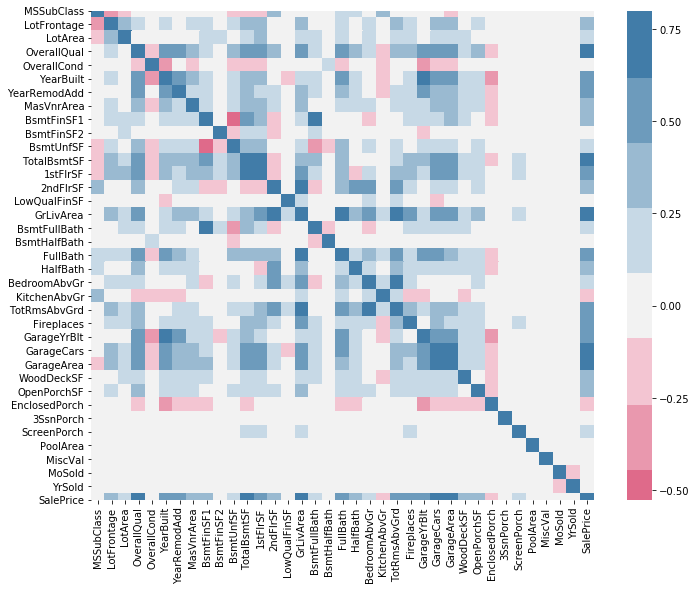

In [15]:
#correlation matrix - Note: only numerical type categories will be displayed.
corrmat = train.corr()
c_map=sns.diverging_palette(1,240, n=9)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, center = 0, vmax=.8, square=True, cmap=c_map)

Personally, I find the full correlation matrix unnecessarily busy, especially as it is a mirror about the diagonal. 

Also, by default the SalePrice (the variable of interest) is squished at the bottom of the matrix. 

Below is an alternative, showing only the bottom triangle, and reversing the order of the rows and columns to get SalePrice on top.

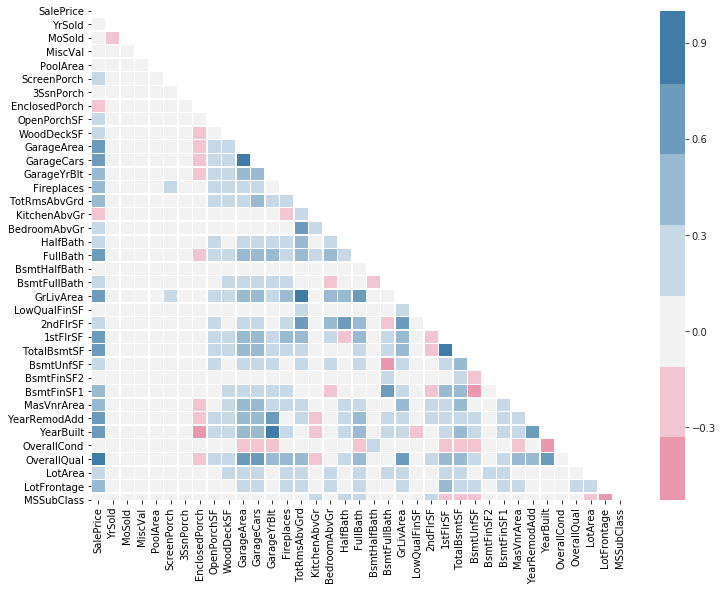

In [16]:
f,ax = plt.subplots(figsize=(12, 9))

#define masked area of heatmap
mask = np.zeros_like(corrmat) # returns numpy array identical in shape to corrmat, filled with zeros
mask[np.triu_indices_from(mask)] = True # takes mask and changes the triangle above the diagonal to 1

#reverse order of rows and columns for display purposes
corrmat=corrmat[corrmat.columns[::-1]].iloc[::-1]

#plot heatmap, applying the mask
with sns.axes_style("white"):
    ax = sns.heatmap(corrmat, center = 0, linewidths=.5, mask=mask, cmap=c_map)

**Feature engineering, for simplification**

In [17]:
# Some "numerical" features are actually categories. Convert these as such

train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [18]:
# Encode some categorical features as ordinal when there is information in the order

train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [19]:
# Simplify qualitative features which have been given quantitative scores

train["SimplOverallQual"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplOverallCond"] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplPoolQC"] = train.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
train["SimplGarageCond"] = train.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })



**Prepare data for modeling**

In [20]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features : 67
Categorical features : 27


In [21]:
# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features for log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

52 skewed numerical features for log transform


/home/mainaminor/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [22]:
# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))

NAs for categorical features in train : 0
Remaining NAs for categorical features in train : 0


In [29]:
# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)
print("New number of features : " + str(train.shape[1]))

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

New number of features : 274
X_train : (1019, 274)
X_test : (437, 274)
y_train : (1019,)
y_test : (437,)


In [24]:
# Standardize numerical features
stdSc = StandardScaler()
tr=stdSc.fit_transform(X_train.loc[:, numerical_features])
te=stdSc.fit_transform(X_test.loc[:, numerical_features])

X_train.loc[:, numerical_features] = tr
X_test.loc[:, numerical_features] = te

/home/mainaminor/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Note: We standardise  after  the partitioning, as we don't want to fit the StandardScaler on some observations that will later be used in the test set.

**Modeling**

**1* Linear Regression without regularization**

R-squared on Training set : 0.9496470831383858
R-squared on Test set : 0.904789505138663


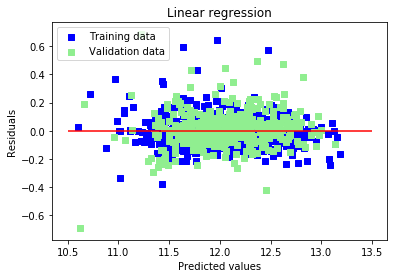

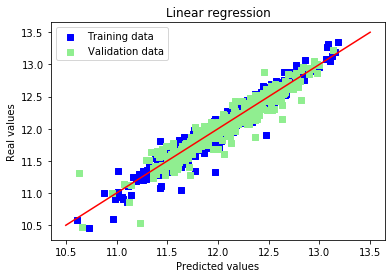

In [30]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("R-squared on Training set :", lr.score(X_train, y_train))
print("R-squared on Test set :", lr.score(X_test, y_test))
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Note the discrepancy between R-square on Training and Test sets. One feature of simple LR is that it solves solely for variance on the test set, and does not appropriate any bias. The result of this is that the model will achieve the best theoretical fit on the training set of any of the family of LR methods, but will always underperform vs the test data. 

**2* Linear Regression with Ridge regularization**

The concept behind regularization is to introduce an additional coefficient to the objective function, the "bias", which means the algorithm is no longer just solving for least squares.

Useful documentation on this and the remainder of the methods discussed here can be found below:

 - https://towardsdatascience.com/bias-variance-and-regularization-in-linear-regression-lasso-ridge-and-elastic-net-8bf81991d0c5
 - https://www.youtube.com/watch?v=NGf0voTMlcs
 

Regularization is a very useful method to handle collinearity, filter out noise from data, and eventually prevent overfitting.  

Best alpha : 30.0
Try again for more precision with alphas centered around 30.0
Best alpha : 27.0
R-squared on Training set : 0.9365156716909497
R-squared on Test set : 0.921871012378638


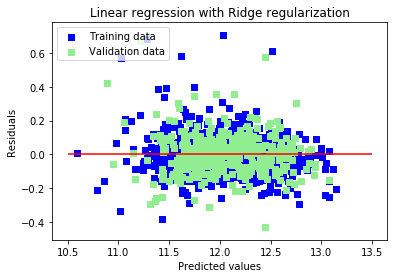

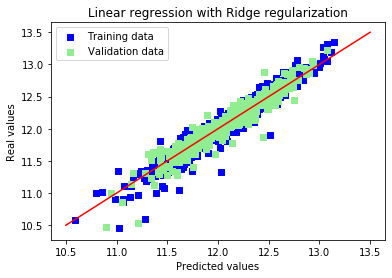

Ridge picked 271 features and eliminated the other 3 features


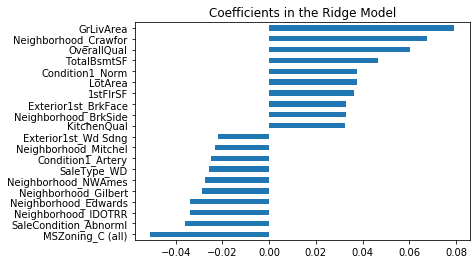

In [26]:
# 2* Ridge
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("R-squared on Training set :", ridge.score(X_train, y_train))
print("R-squared on Test set :", ridge.score(X_test, y_test))
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

Notice that the Training score has got marginally worse compared to simple LR, but the Test score has improved markedly. 

Notice also that Ridge has used almost all of the existing features.

**3* Linear Regression with Lasso regularization (L1 penalty)**

LASSO stands for *Least Absolute Shrinkage and Selection Operator*. In contrast to Ridge, Lasso regularization yields sparse feature vectors : most feature weights will be zero. Sparsity can be useful in practice if we have a high dimensional dataset with many features that are less relevant and need removing.

Best alpha : 0.0006
Try again for more precision with alphas centered around 0.0006
Best alpha : 0.00054
R-squared on Training set : 0.9376060690065727
R-squared on Test set : 0.9268957653967751


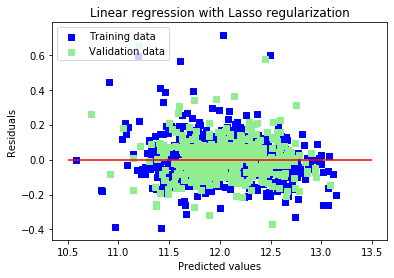

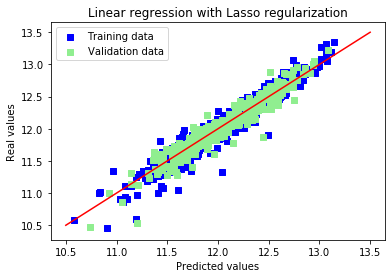

Lasso picked 115 features and eliminated the other 159 features


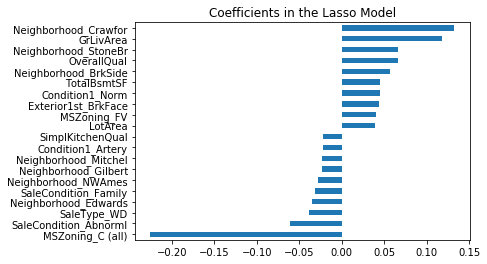

In [27]:
# 3* Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("R-squared on Training set :", lasso.score(X_train, y_train))
print("R-squared on Test set :", lasso.score(X_test, y_test))
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

Notice that Lasso has dropped 150+ features, but still achieves a score very close to the Ridge Score. 

**4* Linear Regression with ElasticNet regularization (L1 and L2 penalty)**

ElasticNet is a compromise between Ridge and Lasso regression. It has a L1 penalty to generate sparsity and a L2 penalty to overcome some of the limitations of Lasso (not discussed here)

Best l1_ratio : 0.9
Best alpha : 0.0006
Try again for more precision with l1_ratio centered around 0.9
Best l1_ratio : 0.9
Best alpha : 0.0006
Now try again for more precision on alpha, with l1_ratio fixed at 0.9 and alpha centered around 0.0006
Best l1_ratio : 0.9
Best alpha : 0.0006
R-squared on Training set : 0.9375727693201468
R-squared on Test set : 0.9268291919170153


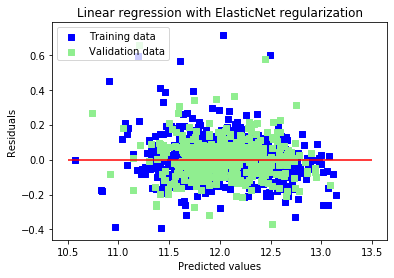

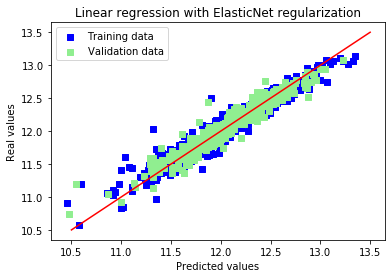

ElasticNet picked 116 features and eliminated the other 158 features


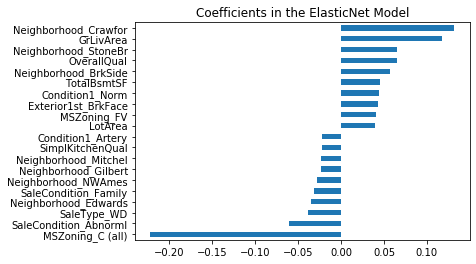

In [28]:
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("R-squared on Training set :", elasticNet.score(X_train, y_train))
print("R-squared on Test set :", elasticNet.score(X_test, y_test))
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

Notice here that the result is nearly identical to what we saw for Lasso. 